# Projektarbeit Digitale Bildverarbeitung

Autor: Dario Villani

Matrikelnummer: 5805250

In diesem Notebook befindet sich der Code der Projektarbeit für das Modul Digitale Bildverarbeitung. Weitere Erläuterungen befinden sich in der Dokumentation, die in dem GitHub-Repository beiliegt.

# Erforderliche Pakete importieren



In [ ]:
import tensorflow as tf

import numpy as np
from tensorflow.keras.preprocessing.image import ImageDataGenerator #Dataset augmentation
from sklearn.model_selection import train_test_split

import math
import matplotlib.pyplot as plt
import seaborn as sn
from sklearn.metrics import confusion_matrix

# Folgende Installationen könnten für die Ausführung benötigt werden


In [ ]:
pip install tensorflow

In [ ]:
pip install matplotlib

In [ ]:
pip install seaborn

In [ ]:
pip install -U scikit-learn

In [ ]:
pip install scipy

# Laden des MNIST-Datensatzes und Vorverarbeiten der Daten

In [ ]:
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()

x_train_normalized = x_train/255
x_test_normalized = x_test/255

x_train= x_train_normalized.reshape(-1, 28, 28, 1)
x_test = x_test_normalized.reshape(-1, 28, 28, 1)

11490434/11490434 [==============================] - 0s 0us/step


# Architektur des Netzes definieren

Im folgenden Code-Abschnitt wird eine Funkton definiert, welche das Netz mit seiner entsprechenden Architektur definiert und kompiliert. Mit der Funktion kann ein Netz mit einem ausgewählten optimizer und einer ausgewählten activation_funtion initialisiert werden.

In [ ]:
def create_model(optimizer, activation_function):
  model = tf.keras.models.Sequential([
    tf.keras.layers.InputLayer(input_shape=(28,28,1)),
    tf.keras.layers.Conv2D(filters=64, kernel_size=2, padding='same', activation = activation_function),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Dropout(0.25),
    tf.keras.layers.Conv2D(filters=64, kernel_size=2, padding='same', activation= activation_function),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Dropout(0.25),
    tf.keras.layers.Conv2D(filters=120, kernel_size=5, padding='same', activation= activation_function),
    tf.keras.layers.Dropout(0.25),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(64, activation= activation_function),
    tf.keras.layers.Dropout(0.25),
    tf.keras.layers.Dense(10, activation='softmax')
  ])
  model.compile(
        optimizer=tf.keras.optimizers.get(optimizer),
        loss='sparse_categorical_crossentropy',
        metrics=['accuracy']
    )

  return model

# Basis-Netz

In diesem Abschnitt wird das Basis-Netz mit einer Standardkonfiguration initialisiert. Daraufhin wird die Parameterzusammensetzung anhand der einzelnen Schichten ausgegeben.

In [ ]:
base_model = create_model('adam', 'relu')
base_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 28, 28, 64)        320       
                                                                 
 max_pooling2d (MaxPooling2  (None, 14, 14, 64)        0         
 D)                                                              
                                                                 
 dropout (Dropout)           (None, 14, 14, 64)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 14, 14, 64)        16448     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 7, 7, 64)          0         
 g2D)                                                            
                                                                 
 dropout_1 (Dropout)         (None, 7, 7, 64)          0

# Training des Basis-Netzes




In [ ]:
base_model.fit(x_train, y_train, batch_size=8, epochs=10, shuffle=True, validation_split=0.2)

Epoch 1/10
6000/6000 [==============================] - 112s 18ms/step - loss: 0.2106 - accuracy: 0.9367 - val_loss: 0.0621 - val_accuracy: 0.9808
Epoch 2/10
6000/6000 [==============================] - 114s 19ms/step - loss: 0.0902 - accuracy: 0.9739 - val_loss: 0.0490 - val_accuracy: 0.9865
Epoch 3/10
6000/6000 [==============================] - 115s 19ms/step - loss: 0.0710 - accuracy: 0.9795 - val_loss: 0.0436 - val_accuracy: 0.9880
Epoch 4/10
6000/6000 [==============================] - 114s 19ms/step - loss: 0.0638 - accuracy: 0.9825 - val_loss: 0.0426 - val_accuracy: 0.9890
Epoch 5/10
6000/6000 [==============================] - 116s 19ms/step - loss: 0.0586 - accuracy: 0.9833 - val_loss: 0.0550 - val_accuracy: 0.9861
Epoch 6/10
6000/6000 [==============================] - 125s 21ms/step - loss: 0.0551 - accuracy: 0.9838 - val_loss: 0.0362 - val_accuracy: 0.9903
Epoch 7/10
6000/6000 [==============================] - 115s 19ms/step - loss: 0.0539 - accuracy: 0.9850 - val_loss: 0

# Testen der Leistung des Basis-Netzes auf den Testdaten

In [ ]:
(test_loss, test_acc) = base_model.evaluate(x_test, y_test, batch_size=8)
print("Loss: ", test_loss)
print("Accuracy: ",test_acc)

1250/1250 [==============================] - 6s 5ms/step - loss: 0.0366 - accuracy: 0.9908
Loss:  0.036646924912929535
Accuracy:  0.9908000230789185


Das Netz weist eine Accuracy von über 99% auf, so wie es in der Zieldefinition des Kapitels Basis-Netz gefordert wurde.





# Hyperparameter-Tuning

In diesem Abschnitt wird das Netz mit verschiedenen Hyperparameter-Konfigurationen trainiert. Dafür wird in den nächsten zwei Code-Abschnitten die Matrix der Hyperparameter angelegt und daraus alle möglichen Parameterkombinationen errechnet und ausgegeben.

In [ ]:
param_grid = {
    'optimizer': ['adam', 'rmsprop'],
    'activation_function': ['tanh', 'relu'],
    'batch_size': [8, 64]
}

In [ ]:
param_combinations = []

for optimizer in param_grid['optimizer']:
    for activation_function in param_grid['activation_function']:
        for batch_size in param_grid['batch_size']:
            param_combinations.append({
                'optimizer': optimizer,
                'activation_function': activation_function,
                'batch_size': batch_size
            })

for params in param_combinations:
    print(params)


{'optimizer': 'adam', 'activation_function': 'tanh', 'batch_size': 8}
{'optimizer': 'adam', 'activation_function': 'tanh', 'batch_size': 64}
{'optimizer': 'adam', 'activation_function': 'relu', 'batch_size': 8}
{'optimizer': 'adam', 'activation_function': 'relu', 'batch_size': 64}
{'optimizer': 'rmsprop', 'activation_function': 'tanh', 'batch_size': 8}
{'optimizer': 'rmsprop', 'activation_function': 'tanh', 'batch_size': 64}
{'optimizer': 'rmsprop', 'activation_function': 'relu', 'batch_size': 8}
{'optimizer': 'rmsprop', 'activation_function': 'relu', 'batch_size': 64}


Die Netze mit den unterschiedlichen Parameterkonfigurationen werden drei mal trainiert, anschließend werden die Genauigkeiten der Netze für die Testdaten gemittelt.

In [ ]:
num_runs = 3
results = []

# Train the model with different hyperparameter-combinations
for params in param_combinations:
    accuracies = []

    for _ in range (num_runs):
        model = create_model(params['optimizer'], params['activation_function'])
        model.fit(x_train, y_train, batch_size=params['batch_size'], epochs=10, shuffle=True, validation_split=0.2)

        # Evaluate the model on the test set
        test_loss, test_accuracy = model.evaluate(x_test, y_test, verbose=2)
        accuracies.append(test_accuracy)

    average_accuracy = (sum(accuracies) / len(accuracies))*100

    results.append({
        'params': params,
        'average_accuracy': average_accuracy
    })
    print("Average accuracy = {:.2f}\nUsed hyperparameters: {}".format(average_accuracy, params))
    print('-' * 40)

Epoch 1/10
6000/6000 [==============================] - 32s 5ms/step - loss: 0.2548 - accuracy: 0.9198 - val_loss: 0.1167 - val_accuracy: 0.9652
Epoch 2/10
6000/6000 [==============================] - 30s 5ms/step - loss: 0.1891 - accuracy: 0.9410 - val_loss: 0.0946 - val_accuracy: 0.9722
Epoch 3/10
6000/6000 [==============================] - 30s 5ms/step - loss: 0.1735 - accuracy: 0.9465 - val_loss: 0.1138 - val_accuracy: 0.9641
Epoch 4/10
6000/6000 [==============================] - 30s 5ms/step - loss: 0.1616 - accuracy: 0.9496 - val_loss: 0.1112 - val_accuracy: 0.9681
Epoch 5/10
6000/6000 [==============================] - 28s 5ms/step - loss: 0.1443 - accuracy: 0.9562 - val_loss: 0.0818 - val_accuracy: 0.9747
Epoch 6/10
6000/6000 [==============================] - 29s 5ms/step - loss: 0.1500 - accuracy: 0.9537 - val_loss: 0.0770 - val_accuracy: 0.9772
Epoch 7/10
6000/6000 [==============================] - 28s 5ms/step - loss: 0.1409 - accuracy: 0.9561 - val_loss: 0.0850 - val_ac

Die drei Hyperparameterkombinationen mit der besten Accuracy werden unten ausgegeben.

In [ ]:
# Sort the results based on average accuracy in descending order
sorted_results = sorted(results, key=lambda x: x['average_accuracy'], reverse=True)

# Print the top three results
print("Top 3 parameter combinations based on average accuracy:")

for i, result in enumerate(sorted_results[:3], 1):
    params = result['params']
    accuracy = result['average_accuracy']
    print(f"{i}. Optimizer: {params['optimizer']}, Activation: {params['activation_function']}, Batch Size: {params['batch_size']}, Average Test Accuracy: {accuracy:.2f}%")

Top 3 parameter combinations based on average accuracy:
1. Optimizer: adam, Activation: relu, Batch Size: 64, Average Test Accuracy: 99.22%
2. Optimizer: rmsprop, Activation: relu, Batch Size: 64, Average Test Accuracy: 99.14%
3. Optimizer: adam, Activation: relu, Batch Size: 8, Average Test Accuracy: 99.11%


# Verbesserung der Genauigkeit mit data augmentation






In diesem Abschnitt wird das Netz mit der "besten" Hyperparamterkonfiguration (best_model) zuerst mit den regulären Trainingsdaten trainiert und die Genauigkeit für die Testdaten ausgegeben. Danach wird das Dataset mittels dataset augmentation verändert und das Netz wird erneut trainiert. Die data augmentation wird mit dem ImageDataGenerator umgesetzt. Die Trainingsbilder werden mit einem maximalen Rotationsbereich von 20° rotiert um ein breiteres Dataset zu erstellen.

In [ ]:
# Splitting the data into training and validation sets
x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=0.2, random_state=42)

# Normal training process
best_model = create_model('adam', 'relu')

best_model.fit(x_train, y_train, batch_size=64, epochs=10, shuffle=True, validation_data=(x_val, y_val))

test_loss, test_accuracy = best_model.evaluate(x_test, y_test, verbose=2)

print(test_accuracy)

# Data Augmentation
datagen = ImageDataGenerator(rotation_range=20, fill_mode='nearest')
datagen.fit(x_train)

# Training with augmented data
best_model = create_model('adam', 'relu')

best_model.fit(datagen.flow(x_train, y_train, batch_size=32), batch_size=64, epochs=10, shuffle=True, validation_data=(x_val, y_val))

test_loss, test_accuracy = best_model.evaluate(x_val, y_val, verbose=2)

print(test_accuracy)



Epoch 1/10
600/600 [==============================] - 128s 210ms/step - loss: 0.3270 - accuracy: 0.8968 - val_loss: 0.0819 - val_accuracy: 0.9755
Epoch 2/10
600/600 [==============================] - 123s 204ms/step - loss: 0.1063 - accuracy: 0.9682 - val_loss: 0.0541 - val_accuracy: 0.9847
Epoch 3/10
600/600 [==============================] - 117s 196ms/step - loss: 0.0720 - accuracy: 0.9773 - val_loss: 0.0476 - val_accuracy: 0.9862
Epoch 4/10
600/600 [==============================] - 120s 200ms/step - loss: 0.0607 - accuracy: 0.9824 - val_loss: 0.0345 - val_accuracy: 0.9897
Epoch 5/10
600/600 [==============================] - 120s 201ms/step - loss: 0.0519 - accuracy: 0.9842 - val_loss: 0.0381 - val_accuracy: 0.9891
Epoch 6/10
600/600 [==============================] - 121s 201ms/step - loss: 0.0438 - accuracy: 0.9866 - val_loss: 0.0457 - val_accuracy: 0.9887
Epoch 7/10
600/600 [==============================] - 122s 203ms/step - loss: 0.0391 - accuracy: 0.9879 - val_loss: 0.0331 -

Das Modell, welches mit dem durch Datenaugmentation manipulierten Datensatz trainiert wurde, erzielt eine verbesserte Genauigkeit auf den Testdaten.

# best_model analysieren




Im folgenden Abschnitt wird das Netz mit der "besten" Hyperparameterauswahl im Detaill analysiert. Zuerst wird das Netz initialisiert und trainiert. Daraufhin wird die Genauigkeit für den Testdatensatz ausgegeben und die Lernkurve des Netzes wird geplottet. Anhand der Confusion Matrix wird ausgewertet, welche Zahl am besten und schlechtesten hervorgesagt wird und welche Zahlen häufig miteinander verwechselt werden. Zum Schluss werden falsch vorhergesagte Zahlen dargestellt, sodass diese betrachtet und analysiert werden können.

In [ ]:
best_model = create_model('adam', 'relu')

history = best_model.fit(x_train, y_train, batch_size=64, epochs=10, shuffle=True, validation_split=0.2)

Epoch 1/10
750/750 [==============================] - 7s 7ms/step - loss: 0.2829 - accuracy: 0.9102 - val_loss: 0.0762 - val_accuracy: 0.9771
Epoch 2/10
750/750 [==============================] - 5s 6ms/step - loss: 0.0895 - accuracy: 0.9738 - val_loss: 0.0467 - val_accuracy: 0.9862
Epoch 3/10
750/750 [==============================] - 4s 6ms/step - loss: 0.0660 - accuracy: 0.9797 - val_loss: 0.0392 - val_accuracy: 0.9882
Epoch 4/10
750/750 [==============================] - 5s 7ms/step - loss: 0.0526 - accuracy: 0.9841 - val_loss: 0.0359 - val_accuracy: 0.9895
Epoch 5/10
750/750 [==============================] - 5s 6ms/step - loss: 0.0453 - accuracy: 0.9861 - val_loss: 0.0319 - val_accuracy: 0.9910
Epoch 6/10
750/750 [==============================] - 4s 6ms/step - loss: 0.0392 - accuracy: 0.9885 - val_loss: 0.0339 - val_accuracy: 0.9894
Epoch 7/10
750/750 [==============================] - 5s 7ms/step - loss: 0.0352 - accuracy: 0.9890 - val_loss: 0.0301 - val_accuracy: 0.9915
Epoch 

In [ ]:
(test_loss, test_acc) = best_model.evaluate(x_test, y_test)
print("Loss: ", test_loss)
print("Accuracy: ",test_acc)

313/313 [==============================] - 1s 3ms/step - loss: 0.0299 - accuracy: 0.9925
Loss:  0.02988470159471035
Accuracy:  0.9925000071525574


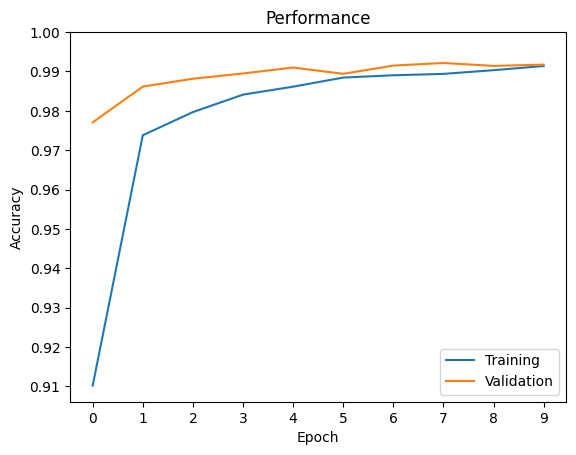

In [ ]:
#Plot learning curve
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Performance')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')

# Labeling in bottom right corner
plt.legend(['Training', 'Validation'], loc='lower right')

# Y-Axis
plt.yticks([i/100 for i in range(int(91), 101, 1)])

# EX-Axis
plt.xticks(range(0, 10))

plt.show()

313/313 [==============================] - 1s 3ms/step


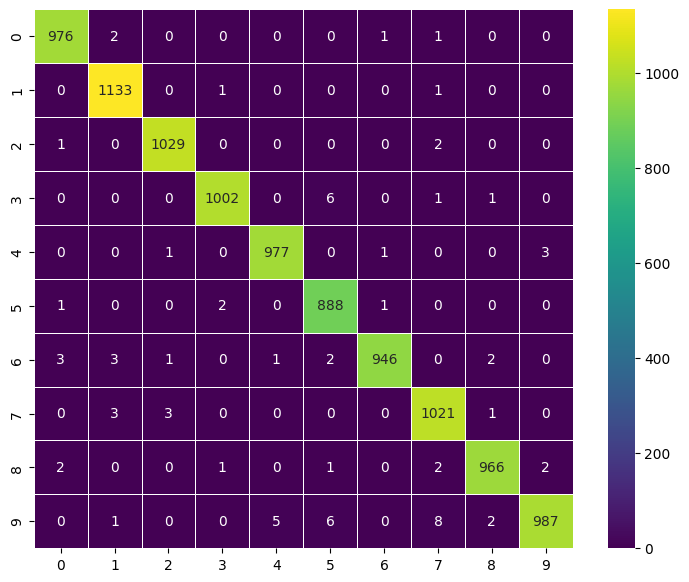

In [ ]:
# Evaluate Model

predictions = np.argmax(best_model.predict(x_test.reshape(-1, 28, 28, 1)), axis=1)

# Build and plot confusion matrix
cm = confusion_matrix(y_test, predictions)

f, ax = plt.subplots(figsize=(9, 7))
sn.heatmap(
    cm,
    annot=True,
    linewidths=.7,
    fmt="d",
    square=True,
    ax=ax,
    cmap="viridis",
)
plt.show()


In [ ]:
class_accuracies = cm.diagonal() / cm.sum(axis=1) #calculate accuracies of the diagonal


# Calculate highest and lowest accuracy of the 10 digits
highest_accuracy_index = np.argmax(class_accuracies)
lowest_accuracy_index = np.argmin(class_accuracies)

highest_accuracy = class_accuracies[highest_accuracy_index]
lowest_accuracy = class_accuracies[lowest_accuracy_index]

print(f'Highest accuracy across all classes: {highest_accuracy} for digit {highest_accuracy_index}')
print(f'Lowest accuracy across all classes: {lowest_accuracy} for digit {lowest_accuracy_index}')

Highest accuracy across all classes: 0.9982378854625551 for digit 1
Lowest accuracy across all classes: 0.9781962338949455 for digit 9


In [ ]:
# confused digtis

# Output most frequently confused pairs of digits
most_confused_pairs = np.argwhere(cm > 0)
confusion_counts = cm[most_confused_pairs[:, 0], most_confused_pairs[:, 1]]

# Exclude the diagonal (correct predictions)
non_diagonal_mask = most_confused_pairs[:, 0] != most_confused_pairs[:, 1]
most_confused_pairs = most_confused_pairs[non_diagonal_mask]
confusion_counts = confusion_counts[non_diagonal_mask]

most_confused_indices = np.argsort(confusion_counts)[::-1][:5]  # The 5 most frequently confused pairs

print("Most frequently confused digit pairs:")
for index in most_confused_indices:
    true_label, predicted_label = most_confused_pairs[index]
    confusion_count = confusion_counts[index]
    print(f'Digit {true_label} was predicted as {predicted_label} {confusion_count} times.')

Most frequently confused digit pairs:
Digit 9 was predicted as 7 8 times.
Digit 9 was predicted as 5 6 times.
Digit 3 was predicted as 5 6 times.
Digit 9 was predicted as 4 5 times.
Digit 6 was predicted as 1 3 times.


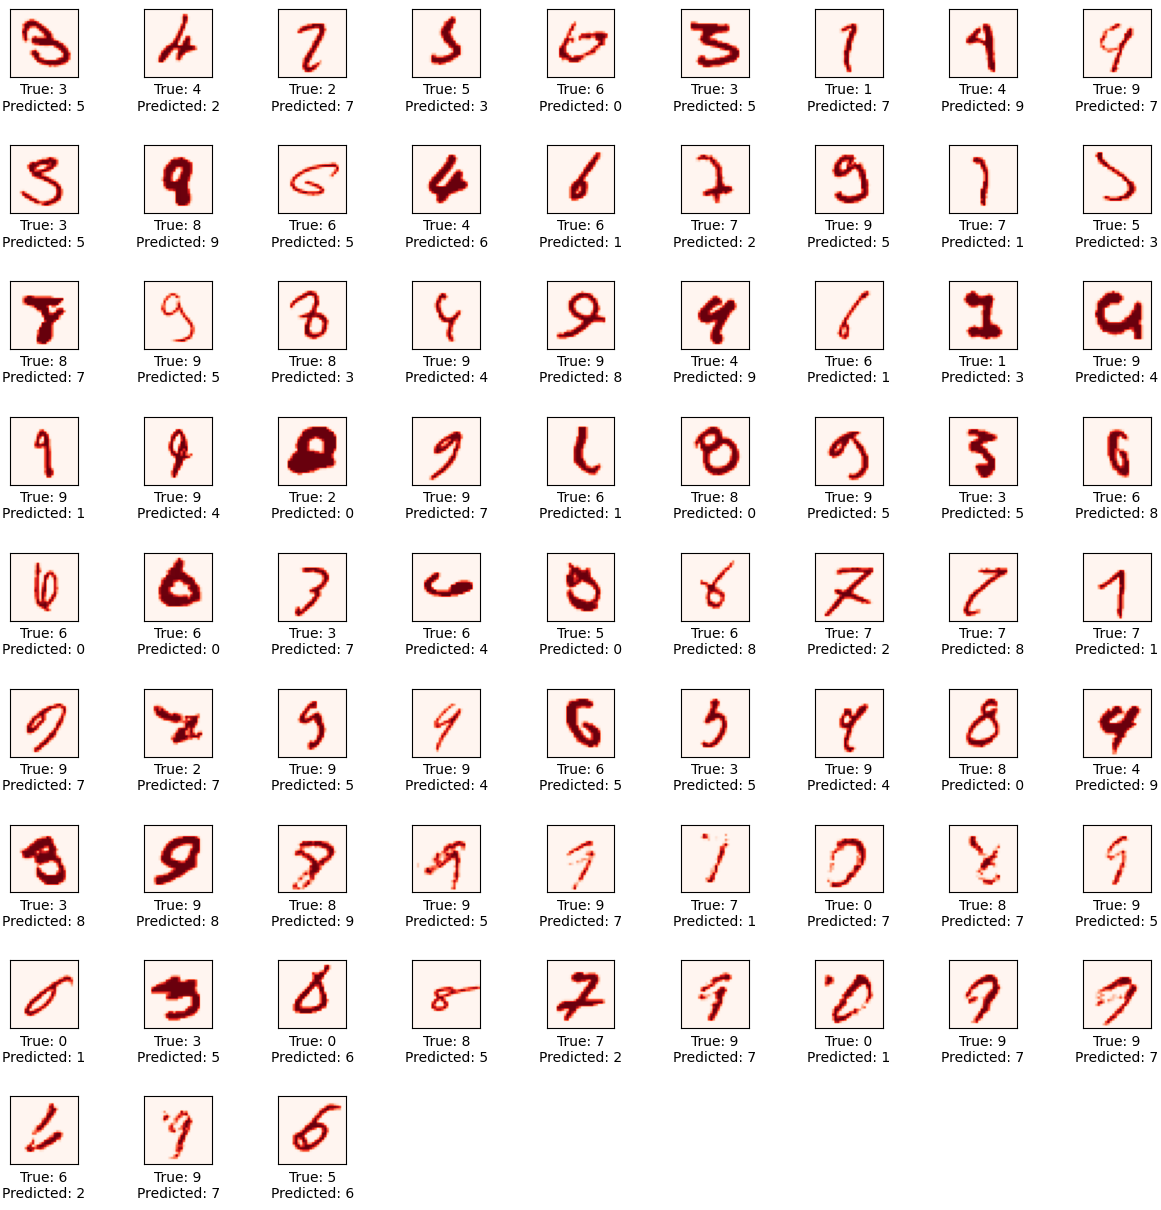

In [ ]:
incorrect_predictions = np.where(predictions != y_test)[0]

# Selecting the first 196 incorrectly predicted digits (or the available number)
numbers_to_display = min(196, len(incorrect_predictions))
num_cells = math.ceil(math.sqrt(numbers_to_display))

plt.figure(figsize=(15, 15))

for i in range(numbers_to_display):
    index = incorrect_predictions[i]
    predicted_label = predictions[index]

    plt.subplot(num_cells, num_cells, i + 1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)

    color_map = 'Reds'  # Display all in red as they were predicted incorrectly
    plt.imshow(x_test_normalized[index].reshape((28, 28)), cmap=color_map)
    plt.xlabel(f'True: {y_test[index]}\nPredicted: {predicted_label}')

plt.subplots_adjust(hspace=1, wspace=0.5)
plt.show()
